In [30]:
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
import folium
import warnings
import re

plt.style.use('ggplot')

TRAIN_PATH = '../input/nlp-getting-started/train.csv'
TEST_PATH = '../input/nlp-getting-started/test.csv'

In [31]:
warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv(TRAIN_PATH)
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [34]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<AxesSubplot:xlabel='target', ylabel='count'>

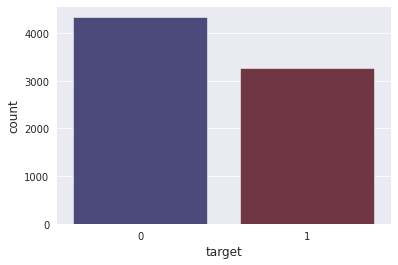

In [35]:
sns.set_style('darkgrid')
sns.countplot(x='target', data=df, palette='icefire')

In [36]:
df_locations_cat = df.groupby(['location', 'target'])[['id']].count().sort_values(by='id', ascending=False)
df_locations_cat

,,id
location,target,
USA,1,67
New York,0,55
USA,0,37
London,0,29
United States,1,27
...,...,...
"Huntsville, Alabama",1,1
Hustletown,1,1
Hyderabad Telangana INDIA,1,1


In [37]:
df_locations_total = df_locations_cat.groupby('location').sum().sort_values(by='id', ascending=False)
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
Hueco Mundo,1
"Hughes, AR",1
"Huntington, WV",1


In [38]:
from functools import lru_cache

@lru_cache(maxsize=100)
def find_long_lat(name: str) -> Tuple[int, int]:
    geolocator = Nominatim(user_agent='user_agent')
    location = geolocator.geocode(name)
    if location:
        return location.longitude, location.latitude
    return 0, 0

In [39]:
print(find_long_lat('Kolkata'))
%time

(88.35769124388872, 22.5414185)
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [40]:
df_locations_total = df_locations_total.iloc[:100]
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
North Carolina,5
Philippines,5
"Cleveland, OH",5


In [41]:
df_locations_total['long'] = df_locations_total \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[0])
df_locations_total['lat'] = df_locations_total  \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[1])

df_locations_total

,id,long,lat
location,,,
USA,104,-100.445882,39.783730
New York,71,-74.006015,40.712728
United States,50,-100.445882,39.783730
London,45,-0.127647,51.507322
Canada,29,-107.991707,61.066692
...,...,...,...
North Carolina,5,-79.039292,35.672964
Philippines,5,122.731210,12.750349
"Cleveland, OH",5,-81.693681,41.499656


In [42]:
map_ = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
# add marker one by one on the map
for i in range(0,len(df_locations_total)):
    folium.Circle(
      location=[df_locations_total.iloc[i]['lat'], df_locations_total.iloc[i]['long']],
      popup=f"{df_locations_total.index[i]}:{df_locations_total.iloc[i]['id']}",
      radius=float(df_locations_total.iloc[i]['id'])*20000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map_)


map_

In [43]:
df_loc_cat_new = df_locations_cat.reset_index()
df_loc_cat_new['target_str'] = df_loc_cat_new['target'].apply(lambda x: 'Disaster' if x == 1 else 'Not disaster')
fig = px.bar(df_loc_cat_new[:50], x='location', y='id', color='target_str')
fig.update_layout(
    title='class count per location (Top 50)',
    xaxis_title='Location', 
    yaxis_title = 'Counts', 
)

### Tweet length

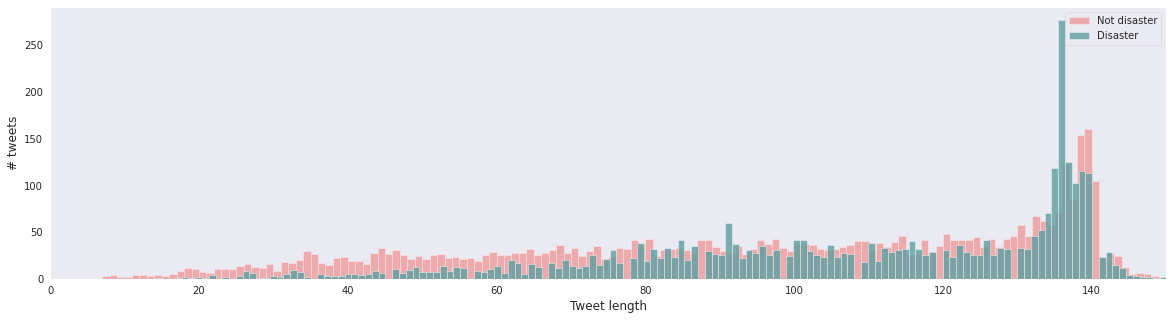

In [44]:
df['tweet_length'] = df['text'].apply(lambda x: len(x))
plt.figure(figsize=(20, 5))
bins = 150
plt.hist(df[df['target'] == 0]['tweet_length'], alpha=0.6, bins=bins, label='Not disaster', color='lightcoral')
plt.hist(df[df['target'] == 1]['tweet_length'], alpha=0.8, bins=bins, label='Disaster', color='cadetblue')
plt.xlabel('Tweet length')
plt.ylabel('# tweets')
plt.legend(loc='upper right')
plt.xlim(0,150)

plt.grid()
plt.show()

In [45]:
df_test = pd.read_csv(TEST_PATH)

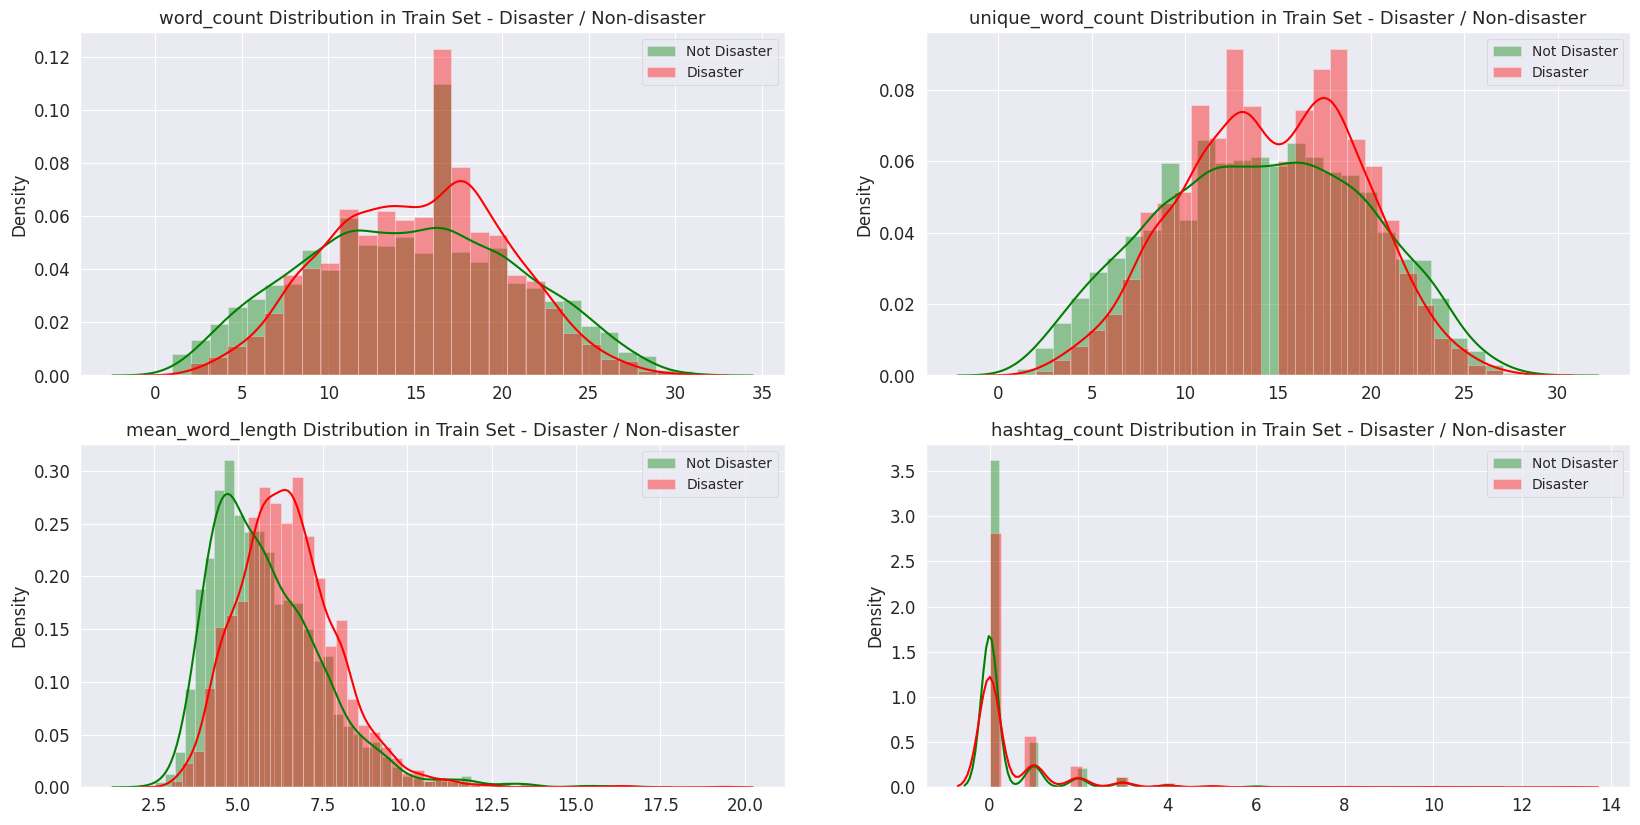

In [46]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(x.split())))

df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in x.split()]))

df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in x if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in x if c == '#']))

FEATURES = ['word_count', 'unique_word_count', 'mean_word_length', 'hashtag_count']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), dpi=100)
for i, feature in enumerate(FEATURES):
    sns.distplot(df[df['target'] == 0][feature], label='Not Disaster', ax=axes[i // 2][i % 2], color='green')
    sns.distplot(df[df['target'] == 1][feature], label='Disaster', ax=axes[i // 2][i % 2], color='red')
    axes[i // 2][i % 2].set_xlabel('')
    axes[i // 2][i % 2].tick_params(axis='x', labelsize=12)
    axes[i // 2][i % 2].tick_params(axis='y', labelsize=12)
    axes[i // 2][i % 2].legend()
    axes[i // 2][i % 2].set_title(f'{feature} Distribution in Train Set - Disaster / Non-disaster', fontsize=13)


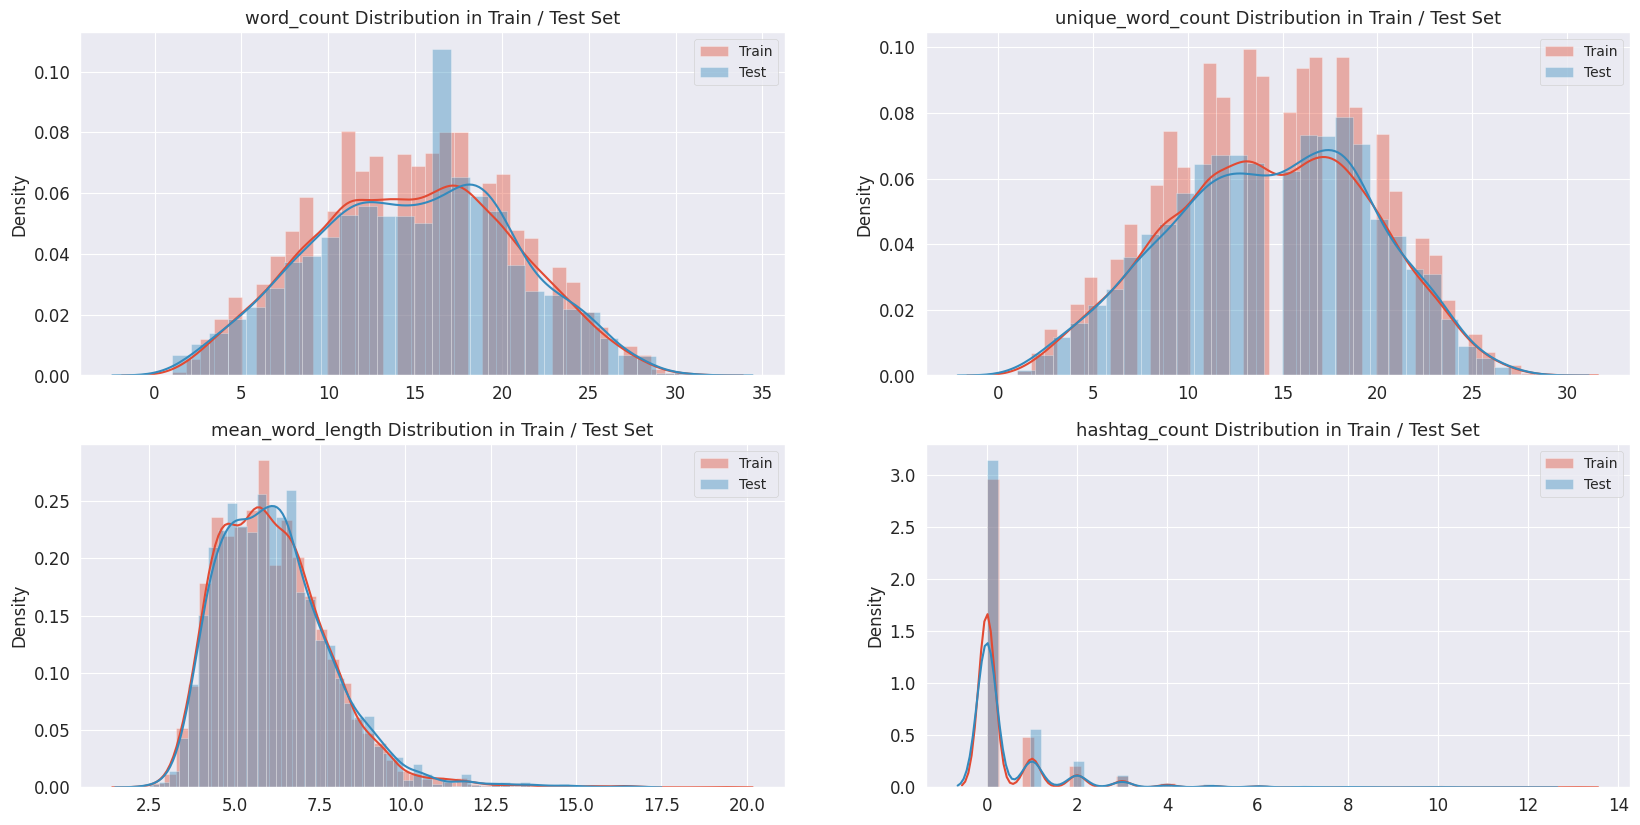

In [47]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 10), dpi=100)
for i, feature in enumerate(FEATURES):
    sns.distplot(df[feature], label='Train', ax=axes[i // 2][i % 2])
    sns.distplot(df_test[feature], label='Test', ax=axes[i // 2][i % 2])

    axes[i // 2][i % 2].set_xlabel('')
    axes[i // 2][i % 2].tick_params(axis='x', labelsize=12)
    axes[i // 2][i % 2].tick_params(axis='y', labelsize=12)
    axes[i // 2][i % 2].legend()
    axes[i // 2][i % 2].set_title(f'{feature} Distribution in Train / Test Set', fontsize=13)


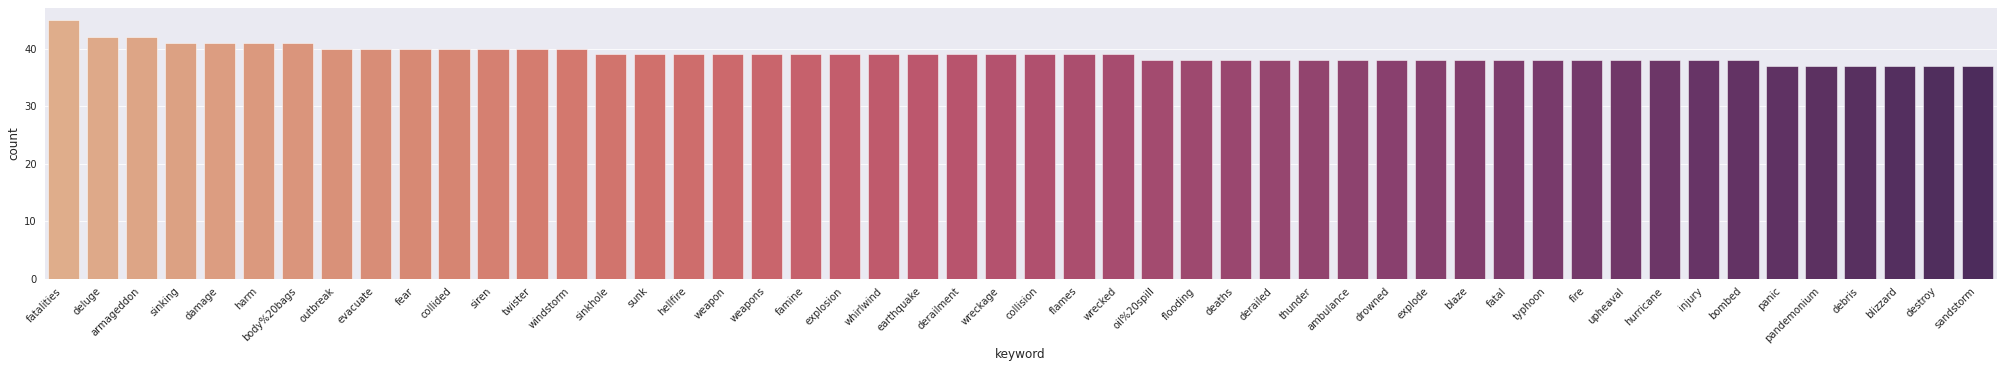

In [48]:
plt.figure(figsize=(35, 5))
kw_counts = sns.countplot(x='keyword', data=df, order=df['keyword'].value_counts()[:50].index, palette='flare')
kw_counts.set_xticklabels(kw_counts.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Data Cleaning

In [49]:
df['keyword'].notnull().sum()

7552

In [50]:
df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

## Hashtag processing and wordcloud

In [51]:
r = re.compile(r'#(\w+)')
# r.findall('lorem #ipsum #dolor #sit #amet #089 #007 hello amazing#help')

df['hashtags'] = df['text'].apply(lambda x: r.findall(x))
df['hashtags'].iloc[:10]

0                      [earthquake]
1                                []
2                                []
3                       [wildfires]
4               [Alaska, wildfires]
5    [RockyFire, CAfire, wildfires]
6                 [flood, disaster]
7                                []
8                                []
9                                []
Name: hashtags, dtype: object

Text(0.5, 1.0, 'Number of Hashtags')

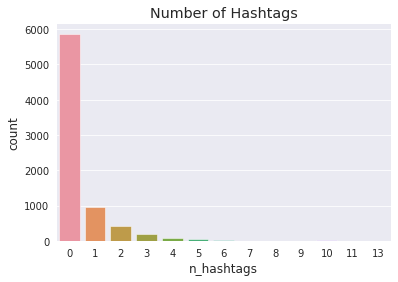

In [52]:
df['n_hashtags'] = df['hashtags'].apply(lambda x: len(x))
fig = sns.countplot(x='n_hashtags', data=df)
fig.set_title("Number of Hashtags")

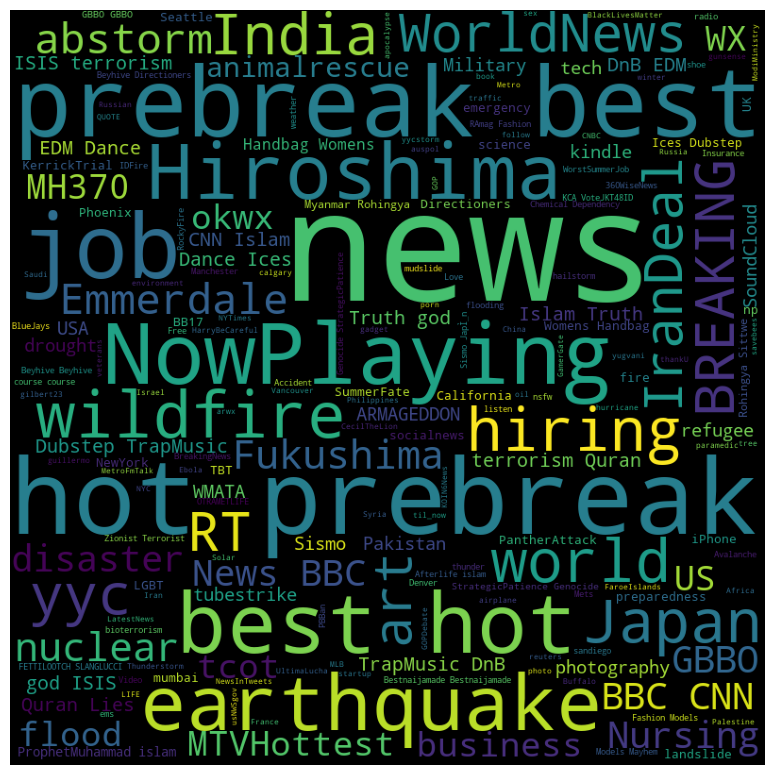

In [53]:
from wordcloud import WordCloud

plt.figure(figsize=(20, 10), dpi=100)
hashtag_corpus = []
for arr in df['hashtags']:
    hashtag_corpus.append(' '.join(arr))
corpus = ' '.join(hashtag_corpus)
wc_hashtags = WordCloud(background_color='black', width=800, height=800).generate(corpus)
plt.imshow(wc_hashtags)
plt.axis('off')
plt.show()


In [56]:
n_dups = len(df[df.duplicated(subset=['text'])])
len_before = len(df)

df.drop_duplicates(subset=['text'], inplace=True)
print(f'{len_before} - {len(df)} = {n_dups} duplicate tweets have been removed')

7613 - 7503 = 110 duplicate tweets have been removed


## Data Cleaning

We have to do some basic preprocessing to remove unnecessary items such as emojis, and urls from the tweets. Additionally, hashtags would need to have the pound sign removed from them as they do not add any additional information (other than identifying hashtags, which we extracted already)

### Removing URLS